In [196]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [197]:
def read_train_and_test(train: str, test: str) -> tuple[DataFrame, DataFrame]:
  df_train = pd.read_csv(train)
  df_train.drop("time", axis=1, inplace=True)
  df_test = pd.read_csv(test)
  df_test.drop("time", axis=1, inplace=True)
  return (df_train, df_test)

In [198]:
def add_lag_features(df: DataFrame, targets: list[str], lag: int) -> tuple[np.ndarray, list[str]]:
  features: list[str] = []
  shifts = []
  for col in targets:
    for i in range(1, lag + 1):
      s = f"{col}_lag_{i}"
      features.append(s)
      shifts.append(df[col].shift(i).rename(s))

  df = pd.concat([df, pd.concat(shifts, axis=1)], axis=1)
  df.dropna(inplace=True)
  X = df[features].values
  y = df[targets].values
  return X, y

In [199]:
def preprocess(df_train: DataFrame, df_test: DataFrame, lag: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
  if set(df_train.columns) != set(df_test.columns):
    raise ValueError("columns set in two DataFrame is not equivalent")

  sc = StandardScaler().set_output(transform='pandas')
  df_train = sc.fit_transform(df_train)
  df_test = sc.transform(df_test)

  targets = df_train.columns
  X_train, y_train = add_lag_features(df_train, targets, lag)
  X_test, y_test = add_lag_features(df_test, targets, lag)


  X_train = X_train.reshape(X_train.shape[0], -1, lag)
  X_test = X_test.reshape(X_test.shape[0], -1, lag)

  return (X_train, y_train, X_test, y_test)

In [200]:
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score

def print_result(y_train, y_train_pred, y_test, y_test_pred):
  print("Train R2-squared:", r2_score(y_train, y_train_pred))
  print("Test R2-square:", r2_score(y_test, y_test_pred))
  print("Train MAPE:", mean_absolute_percentage_error(y_train, y_train_pred))
  print("Test MAPE:", mean_absolute_percentage_error(y_test, y_test_pred))
  print("Train RMSE:", root_mean_squared_error(y_train, y_train_pred))
  print("Test RMSE:", root_mean_squared_error(y_test, y_test_pred))

In [201]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self, feature: int, lag: int, conv: list[int] = [4, 8], line: list[int] = [64, 32], dropout=0.0):
    super().__init__()
    self.feature = feature
    self.lag = lag
    self.conv1 = nn.Conv1d(
      in_channels=feature,
      out_channels=conv[0],
      kernel_size=3,
      stride=1,
      padding=1)
    self.conv2 = nn.Conv1d(
      in_channels=conv[0],
      out_channels=conv[1],
      kernel_size=3,
      stride=1,
      padding=1
    )
    self.dropout=nn.Dropout(dropout, inplace=True)
    self.flatten_size = conv[1]*(lag//2//2)
    self.fc1 = nn.Linear(self.flatten_size, line[0])
    self.fc2 = nn.Linear(line[0], line[1])
    self.fc3 = nn.Linear(line[1], feature)


  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool1d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool1d(X, 2, 2)
    X = self.dropout(X)
    X = X.view(-1, self.flatten_size)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return X

In [202]:
def count_parameters(model: ConvolutionalNetwork):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [203]:
import time

def learn(*, epochs, train_data, test_data, model, criterion, optimizer):
  start_time = time.time()

  train_losses = []
  test_losses = []

  for i in range(epochs):
    size = 0
    for j, (X_train, y_train) in enumerate(train_data):
      y_pred = model(X_train)
      loss = criterion(y_pred, y_train)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      size += X_train.shape[0]
    if j % 5 == 0:
      print(f'epoch: {i:2} batch: {j:2} [{size}/{len(train_data.dataset)}] loss: {loss.item()}')

    with torch.no_grad():
      for j, (X_test, y_test) in enumerate(test_data):
        y_val = model(X_test)
    test_losses.append(criterion(y_val, y_test).item())

    # if i % 50 == 0:
    train_losses.append(loss.item())

  print(f'\nDuration: {time.time() - start_time:.0f} seconds')
  plt.plot(train_losses, label='train loss')
  plt.plot(test_losses, label='test loss')
  plt.legend()
  len(train_losses)


In [204]:
def cnn(*, train_path, test_path, batch_size, lag, epochs, conv, line, dropout):
  df_train, df_test = read_train_and_test(train_path, test_path)
  X_train, y_train, X_test, y_test = preprocess(df_train=df_train, df_test=df_test, lag=lag)

  X_train_ts = torch.FloatTensor(X_train).cuda()
  y_train_ts = torch.FloatTensor(y_train).cuda()
  X_test_ts = torch.FloatTensor(X_test).cuda()
  y_test_ts = torch.FloatTensor(y_test).cuda()

  train_data = DataLoader(TensorDataset(X_train_ts, y_train_ts), batch_size=batch_size, shuffle=True)
  test_data = DataLoader(TensorDataset(X_test_ts, y_test_ts), batch_size=batch_size, shuffle=True)

  shape = X_train.shape
  torch.manual_seed(42)
  model = ConvolutionalNetwork(shape[1], shape[2], conv, line, dropout).cuda()
  print(model)
  count_parameters(model)

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  learn(epochs=epochs, train_data=train_data, test_data=test_data, model=model, criterion=criterion, optimizer=optimizer)

  y_train_pred = model(X_train_ts)
  y_test_pred = model(X_test_ts)
  print_result(y_train_ts.cpu().detach().numpy(), y_train_pred.cpu().detach().numpy(), y_test_ts.cpu().detach().numpy(), y_test_pred.cpu().detach().numpy())

ConvolutionalNetwork(
  (conv1): Conv1d(5, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(2, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.0, inplace=True)
  (fc1): Linear(in_features=28, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=5, bias=True)
)
    30
     2
    24
     4
   448
    16
   128
     8
    40
     5
______
   705

Duration: 3 seconds
Train R2-squared: 0.8501808047294617
Test R2-square: 0.00020560025586746633
Train MAPE: 0.5787752270698547
Test MAPE: 1.5370733737945557
Train RMSE: 0.2608690857887268
Test RMSE: 0.4860258996486664


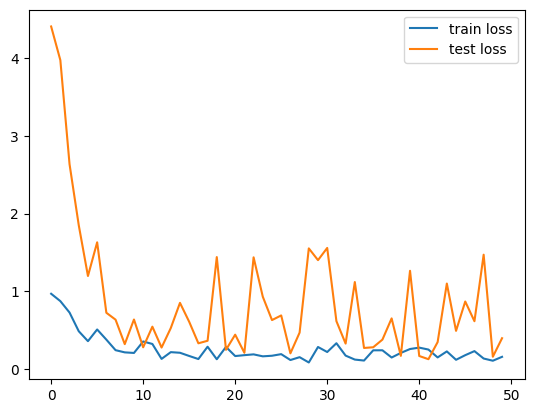

In [212]:
path = "../data/vn30/{}.csv"
train_path=path.format("ACB_train")
test_path=path.format("ACB_test")
cnn(train_path=train_path,
    test_path=test_path,
    batch_size=64,
    lag=30,
    epochs=50,
    conv=[2, 4],
    line=[16, 8],
    dropout=0.0,
)